# Tarea No. 1: Gradient Descent en Tensorflow

La tarea práctica consiste en usar el mismo dataset del proyecto del curso pasado y e implementar gradient descent aplicado a regresión con este(usando la variable con mayor correlación elegida en el proyecto en anterior(solo una de las 2 del proyecto)),si no terminaron el proyecto anterior no se preocupen, no hay que hacer todo el proyecto, solo el entrenamiento con gradient descent pero usando tensorflow y usar tensorboard para monitorear que el error disminuya conforme avanzan las iteraciones "en vivo"(en lugar de hacerlo con matplotlib hasta el final como lo hicimos antes).

Pueden usar el siguiente ejemplo de regresión con tensorflow: https://www.geeksforgeeks.org/linear-regression-using-tensorflow/ o el notebook usado en clase.
Para la parte de Tensorboard, este nos permite visualizar mucha información relevante, pero nos centraremos en 2 cosas :

- La curva de aprendizaje(disminución de error MSE en el tiempo)(en la la pestaña "scalars")
- El grafo que representa a nuestro modelo (en la pestaña "graphs")

Requisitos:

- Utilizar solo operaciones vectorizadas.
- Usar mini-batch gradient descent (tamaño de mini-batch debe ser un hyper-parametro con el cual se debe experimentar.)
- Utilizar tensorboard(https://youtu.be/FEu1R3t_-4I):

    - Agregar el grafo del modelo.
    - Usar operaciones con nombre y usar name_spaces para mejorar el orden.
    - Agregar un summary.scalar para monitorear el MSE.
    - Aplicar reutilización de código: por ejemplo usar programación orientada a objetos para crear el modelo y/o definir el entrenamiento dentro de funciones de python.
    - Utilizar las funciones reutilizables de entrenamiento para ejecutar al menos 10 experimentos (variable numero de iteraciones, diferente learning rate y diferente tamaño de mini-batch)
    - Definir un string de configuración para cada experimento.
    - Crear un directorio para cada experimento basado en el string de configuración.
    - Utilizar un enfoque investigación científica: antes del experimento formular una hipótesis del comportamiento experado, ejecutar el experimento y utilizar los resultados de tensorboard para conculir.
    - Basado en los resultados experimentales obtenidos con tensorboard crear una conclusión general y elegir el mejor experimento.
    - Agregar el contenido de tensorboard al notebook(pueden ser screenshots=
    - Subir el notebook a github y agregar al GES el link
    - No utilizar tf.train.GradientDescentOptimizer ni tf.losses


In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt

# Habilitar la compatibilidad con tensorflow v1 si se tienen tensorflow v2
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")


Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


## Carga de los datos

In [2]:
# Se cargan los datos sobre predicción de precios de casas
Data = np.load('proyecto_training_data.npy')

# Dimensiones de los datos
filas, cols = Data.shape

# Se "shufflelean" los datos
rng = np.random.default_rng()
rng.shuffle(Data, axis=0)

# Límite para extraer los datos de entrenamiento (80%)
lim_sup_train = int(filas*0.8)

# Extracción de datos de entrenamiento (80%) y de validación (20%)
train_data = Data[0:lim_sup_train, :]
test_data = Data[lim_sup_train:filas, :]

## Grafo para Modelo de Regresión Lineal

Función para entrenar un modelo de regresión lineal de una variable con la forma y = mx + b

![grafo](grafo.png)

In [3]:
# Se reinicia la creación del grafo creado
tf.reset_default_graph()

# Se crea un objeto de tipo grafo
grafo = tf.Graph()

# Se incluyen nodos dentro del grafo
with grafo.as_default():

    # Se definen los vectores X (variable 1) y Y (variable 2)
    # X: Tantas filas como datos. 2 columnas - Una de datos y otra de unos
    # Y: Datos restantes que producirá
    X = tf.placeholder(tf.float32, [None, 1], "X")
    Y = tf.placeholder(tf.float32, [None, 1], "Y")

    # Número de filas de los datos
    numero_filas = tf.cast(tf.shape(X)[0], dtype=tf.float32)

    # Se inicializan los parámetros "m" y "b"
    M = tf.Variable(tf.zeros((1, 1)), name="M", dtype=tf.float32)
    B = tf.Variable(tf.zeros((1, 1)), name="B", dtype=tf.float32)

    # Se agregan las constantes del modelo lineal a tensorboard
    M_summary = tf.summary.scalar("Pendiente", M[0,0])
    B_summary = tf.summary.scalar("Intercept", B[0,0])

    # Hiperparámetros
    learning_rate = tf.placeholder(dtype="float", name="lr")

    # Predicción de la salida dados los parámetros M y B
    with tf.name_scope("predict"):
        Y_hat = tf.add(tf.matmul(X, M), B)

    # Cálculo del error 
    with tf.name_scope("error"):
        error = tf.reduce_sum(tf.pow(Y_hat - Y, 2)) / (2 * numero_filas)

        # Incluir el error en la parte de "Scalars" de tensorboard
        error_summary = tf.summary.scalar("Error", error)

    # Obtener el valor de los gradientes para M y B
    grads = tf.gradients(error, [M, B])

    # Actualizar los parámetros del algoritmo
    with tf.name_scope("update_params"):
        delta_M = tf.assign(M, M - learning_rate * grads[0])
        delta_B = tf.assign(B, B - learning_rate * grads[1])
        delta_params = tf.group(delta_M, delta_M)

    # Inicializar variables globales
    init = tf.global_variables_initializer()


## Entrenamiento de Modelo

In [4]:
def Train(x1, x2, lr, epochs):

    # Clears the default graph stack and resets the global default graph.
    tf.reset_default_graph()

    with tf.Session(graph = grafo) as sess:
        
        # Inicializa todas las variables de ser necesario
        tf.initialize_all_variables().run()

        # Crea un directorio para tensorboard
        # Generalmente el directorio "padre" de tensorboard es "graphs" pero puede cambiarse
        writer = tf.summary.FileWriter((f'./graphs/model_lr={str(lr)}, epochs={str(epochs)}'), sess.graph)

        # Inicializar el grafo
        sess.run(init)

        # Iterar para cada Epoch
        for epoch in range(epochs):
            
            # Se definen los inputs del grafo
            inputs_grafo = {
                X: x1,
                Y: x2,
                learning_rate: lr
            }

            # Se corre el grafo con los datos elegidos
            sess.run(delta_params, feed_dict=inputs_grafo)

            # Se agregan todos los escalares al tensorboard
            m, b, e = sess.run([M_summary, B_summary, error_summary], feed_dict=inputs_grafo)
            writer.add_summary(m, epoch)
            writer.add_summary(b, epoch)
            writer.add_summary(e, epoch)
        
        pendiente = M.eval()
        intercept = B.eval()
            
        # Finalizar el "writer" hacia tensor board
        writer.close()

    return pendiente, intercept

## Ejecutar entrenamiento

In [22]:
# Diferentes combinaciones de variables necesitan learning rates diferentes
# En el siguiente diccionario se colocaron las diferentes combinaciones que funcionaron bien
comb = {
    "x1": {
        "datos": Data[:,1],
        "lr": 0.01
    },

    "x2": {
        "datos": Data[:,2],
        "lr": 0.000001
    },

    "x3": {
        "datos": Data[:,3],
        "lr": 0.001
    }, 

    "x4": {
        "datos": Data[:,4],
        "lr": 0.0000001
    },

    "x5": {
        "datos": Data[:,5],
        "lr": 0.00001
    }
}

Text(0.5, 1.0, 'Evolución de Modelo')

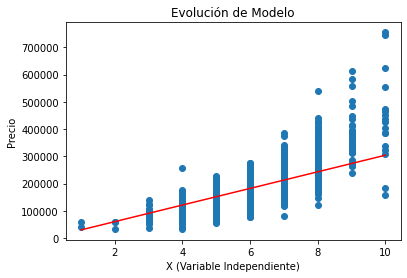

In [24]:
# Para ejecutar Tensorboard escribir la siguiente línea en la consola
#   cd directorio_donde_esta_graphs
#   tensorboard --logdir="./graphs" --port 6006

# Variable deseada (todas funcionan menos x5)
comb_sel = "x1"
comb_sel = comb[comb_sel]

# Primeras dos variables
x1 = np.reshape(comb_sel["datos"], (len(comb_sel["datos"]), 1))
x2 = np.reshape(Data[:,0], (len(Data[:,0]), 1))
m, b = Train(x1, x2, comb_sel["lr"], 100)

# Gráfica del modelo
fig, ax = plt.subplots()

# Setup de las variables "globales" de la clase
x_model = np.linspace(min(x1), max(x1), 1000)
y_model = m*x_model + b

# Setup de la línea recta que corresponde al modelo
line, = ax.plot(x_model, y_model, 'r')

# Gráfica de los puntos con los datos (estática)
ax.scatter(x1, x2)
ax.set_xlabel("X (Variable Independiente)")
ax.set_ylabel("Precio")
ax.set_title("Evolución de Modelo")